# BirdCLEF 2024 [Train]

This is the baseline of EfficientNetB0 with PyTorch. I strive to simplify the process to get started faster. Therefore, I only use data from BirdCLEF 2024 (no extended data from BirdCLEF'23, 22, 21, and other sources) and unlabeled soundscapes are also not used. Besides, PyTorch-Lightning is employed to organize the training.

Hope this notebook is useful for you!!

* [Pre-Processing](https://www.kaggle.com/code/zijiangyang1116/birdclef-24-speed-up-audio-to-spec-via-cupy)
* [The inference Notebook](https://www.kaggle.com/code/zijiangyang1116/birdclef-24-efficientnetb0-pytorch-inference)

## Features
- Implement with PyTorch and PyTorch-Lightning
- Speed up audio-to-spec. via CuPy
- Use EfficientNetB0 from torchvision

## Table of Contents

- [Import Packages](#Import-Packages)
- [Configuration](#Configuration)
- [Dataset & Dataloader](#Dataset-&-Dataloader)
- [Model](#Model)
- [Functions of Training Loop](#Functions-of-Training-Loop)
- [Training](#Training)

## Update

- V3: fix bug - After validation, self.validation_step_outputs should be cleared.
- V4: use XYMasking

# Import packages

Import all required packages.

In [1]:
import os
import gc
import sys
import cv2
import math
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import librosa
from scipy import signal as sci_signal

import torch
from torch import nn
from torchvision.models import efficientnet

import albumentations as albu

import pytorch_lightning as pl
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar

# import score function of BirdCLEF
sys.path.append('/kaggle/input/birdclef-roc-auc')
sys.path.append('/kaggle/usr/lib/kaggle_metric_utilities')
from metric import score

# Configuration

Hyper-paramters

In [2]:
class config:

    # == global config ==
    SEED = 2024  # random seed
    DEVICE = 'cuda'  # device to be used
    MIXED_PRECISION = False  # whether to use mixed-16 precision
    OUTPUT_DIR = '/kaggle/working/'  # output folder

    # == data config ==
    DATA_ROOT = '/kaggle/input/birdclef-2024'  # root folder
    PREPROCESSED_DATA_ROOT = '/kaggle/input/birdclef24-spectrograms-via-cupy'
    LOAD_DATA = True  # whether to load data from pre-processed dataset
    FS = 32000  # sample rate
    N_FFT = 1095  # n FFT of Spec.
    WIN_SIZE = 412  # WIN_SIZE of Spec.
    WIN_LAP = 100  # overlap of Spec.
    MIN_FREQ = 40  # min frequency
    MAX_FREQ = 15000  # max frequency

    # == model config ==
    MODEL_TYPE = 'efficientnet_b0'  # model type

    # == dataset config ==
    BATCH_SIZE = 32  # batch size of each step
    N_WORKERS = 4  # number of workers

    # == AUG ==
    USE_XYMASKING = True  # whether use XYMasking

    # == training config ==
    FOLDS = 10  # n fold
    EPOCHS = 15  # max epochs
    LR = 1e-3  # learning rate
    WEIGHT_DECAY = 1e-5  # weight decay of optimizer

    # == other config ==
    VISUALIZE = True  # whether to visualize data and batch

print('fix seed')
pl.seed_everything(config.SEED, workers=True)

fix seed


2024

In [3]:
# labels
label_list = sorted(os.listdir(os.path.join(config.DATA_ROOT, 'train_audio')))
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')

Using 2 GPU(s)


# Dataset & Dataloader

1. [Load Metadata](#Load-Metadata): Load metadata from dataset
2. [Pre-Processing](#Pre-Processing): The function to convert audio to spectrograms.
3. [Dataset](#Dataset): Yield samples
4. [Augmentation](#Augmentation): Data augmentation
5. [Verify](#Verify): Verify the dataset and dataloader work well

## Load Metadata

In [5]:
metadata_df = pd.read_csv(f'{config.DATA_ROOT}/train_metadata.csv')
metadata_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg


In [6]:
train_df = metadata_df[['primary_label', 'rating', 'filename']].copy()

# create target
train_df['target'] = train_df.primary_label.map(label2id)
# create filepath
train_df['filepath'] = config.DATA_ROOT + '/train_audio/' + train_df.filename
# create new sample name
train_df['samplename'] = train_df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])

print(f'find {len(train_df)} samples')

train_df.head()

find 24459 samples


,primary_label,rating,filename,target,filepath,samplename
0,asbfly,5.0,asbfly/XC134896.ogg,0,/kaggle/input/birdclef-2024/train_audio/asbfly...,asbfly-XC134896
1,asbfly,2.5,asbfly/XC164848.ogg,0,/kaggle/input/birdclef-2024/train_audio/asbfly...,asbfly-XC164848
2,asbfly,2.5,asbfly/XC175797.ogg,0,/kaggle/input/birdclef-2024/train_audio/asbfly...,asbfly-XC175797
3,asbfly,4.0,asbfly/XC207738.ogg,0,/kaggle/input/birdclef-2024/train_audio/asbfly...,asbfly-XC207738
4,asbfly,4.0,asbfly/XC209218.ogg,0,/kaggle/input/birdclef-2024/train_audio/asbfly...,asbfly-XC209218


## Pre-Processing

To speed up audio-to-spectrogram, we employ CuPy. `CuPy is a NumPy/SciPy-compatible array library for GPU-accelerated computing with Python,` which can significant improve the efficiency of conversion. For more detailed analysis, you can refer to this [notebook](https://www.kaggle.com/code/zijiangyang1116/birdclef-24-speed-up-audio-to-spec-via-cupy).

Please note, in this notebook, we only use the **center 5 sec** of each audio. By default (`Load_DATA=True`), pre-processed data will be loaded from the [dataset](https://www.kaggle.com/datasets/zijiangyang1116/birdclef24-spectrograms-via-cupy). If `Load_DATA` is set to `False`, spectrograms will be create with `CuPy` (about 30 minites).

In [7]:
def oog2spec_via_scipy(audio_data):
    # handles NaNs
    mean_signal = np.nanmean(audio_data)
    audio_data = np.nan_to_num(audio_data, nan=mean_signal) if np.isnan(audio_data).mean() < 1 else np.zeros_like(audio_data)

    # to spec.
    frequencies, times, spec_data = sci_signal.spectrogram(
        audio_data,
        fs=config.FS,
        nfft=config.N_FFT,
        nperseg=config.WIN_SIZE,
        noverlap=config.WIN_LAP,
        window='hann'
    )

    # Filter frequency range
    valid_freq = (frequencies >= config.MIN_FREQ) & (frequencies <= config.MAX_FREQ)
    spec_data = spec_data[valid_freq, :]

    # Log
    spec_data = np.log10(spec_data + 1e-20)

    # min/max normalize
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()

    return spec_data

In [8]:
def oog2spec_via_cupy(audio_data):

    import cupy as cp
    from cupyx.scipy import signal as cupy_signal

    audio_data = cp.array(audio_data)

    # handles NaNs
    mean_signal = cp.nanmean(audio_data)
    audio_data = cp.nan_to_num(audio_data, nan=mean_signal) if cp.isnan(audio_data).mean() < 1 else cp.zeros_like(audio_data)

    # to spec.
    frequencies, times, spec_data = cupy_signal.spectrogram(
        audio_data,
        fs=config.FS,
        nfft=config.N_FFT,
        nperseg=config.WIN_SIZE,
        noverlap=config.WIN_LAP,
        window='hann'
    )

    # Filter frequency range
    valid_freq = (frequencies >= config.MIN_FREQ) & (frequencies <= config.MAX_FREQ)
    spec_data = spec_data[valid_freq, :]

    # Log
    spec_data = cp.log10(spec_data + 1e-20)

    # min/max normalize
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()

    return spec_data.get()

In [9]:
if config.LOAD_DATA:
    print('load from file')
    all_bird_data = np.load(f'{config.PREPROCESSED_DATA_ROOT}/spec_center_5sec_256_256.npy', allow_pickle=True).item()
else:
    all_bird_data = dict()
    for i, row_metadata in tqdm(train_df.iterrows()):

        # load ogg
        audio_data, _ = librosa.load(row_metadata.filepath, sr=config.FS)

        # crop
        n_copy = math.ceil(5 * config.FS / len(audio_data))
        if n_copy > 1: audio_data = np.concatenate([audio_data]*n_copy)

        start_idx = int(len(audio_data) / 2 - 2.5 * config.FS)
        end_idx = int(start_idx + 5.0 * config.FS)
        input_audio = audio_data[start_idx:end_idx]

        # ogg to spec.
        input_spec = oog2spec_via_cupy(input_audio)

        input_spec = cv2.resize(input_spec, (256, 256), interpolation=cv2.INTER_AREA)

        all_bird_data[row_metadata.samplename] = input_spec.astype(np.float32)

    # save to file
    np.save(os.path.join(config.OUTPUT_DIR, f'spec_center_5sec_256_256.npy'), all_bird_data)

load from file


## Dataset

To yield samples.

In [10]:
class BirdDataset(torch.utils.data.Dataset):

    def __init__(
        self,
        metadata,
        augmentation=None,
        mode='train'
    ):
        super().__init__()
        self.metadata = metadata
        self.augmentation = augmentation
        self.mode = mode

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):

        row_metadata = self.metadata.iloc[index]

        # load spec. data
        input_spec = all_bird_data[row_metadata.samplename]

        # aug
        if self.augmentation is not None:
            input_spec = self.augmentation(image=input_spec)['image']

        # target
        target = row_metadata.target

        return torch.tensor(input_spec, dtype=torch.float32), torch.tensor(target, dtype=torch.long)

## Augmentation

In [11]:
def get_transforms(_type):

    if _type == 'train':
        return albu.Compose([
            albu.HorizontalFlip(0.5),
            albu.XYMasking(
                p=0.3,
                num_masks_x=(1, 3),
                num_masks_y=(1, 3),
                mask_x_length=(1, 10),
                mask_y_length=(1, 20),
            ) if config.USE_XYMASKING else albu.NoOp()
        ])
    elif _type == 'valid':
        return albu.Compose([])

## Verify

In [12]:
def show_batch(ds, row=3, col=3):
    fig = plt.figure(figsize=(10, 10))
    img_index = np.random.randint(0, len(ds)-1, row*col)

    for i in range(len(img_index)):
        img, label = dummy_dataset[img_index[i]]

        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()

        ax = fig.add_subplot(row, col, i + 1, xticks=[], yticks=[])
        ax.imshow(img, cmap='jet')
        ax.set_title(f'ID: {img_index[i]}; Target: {label}')

    plt.tight_layout()
    plt.show()

(256, 256)


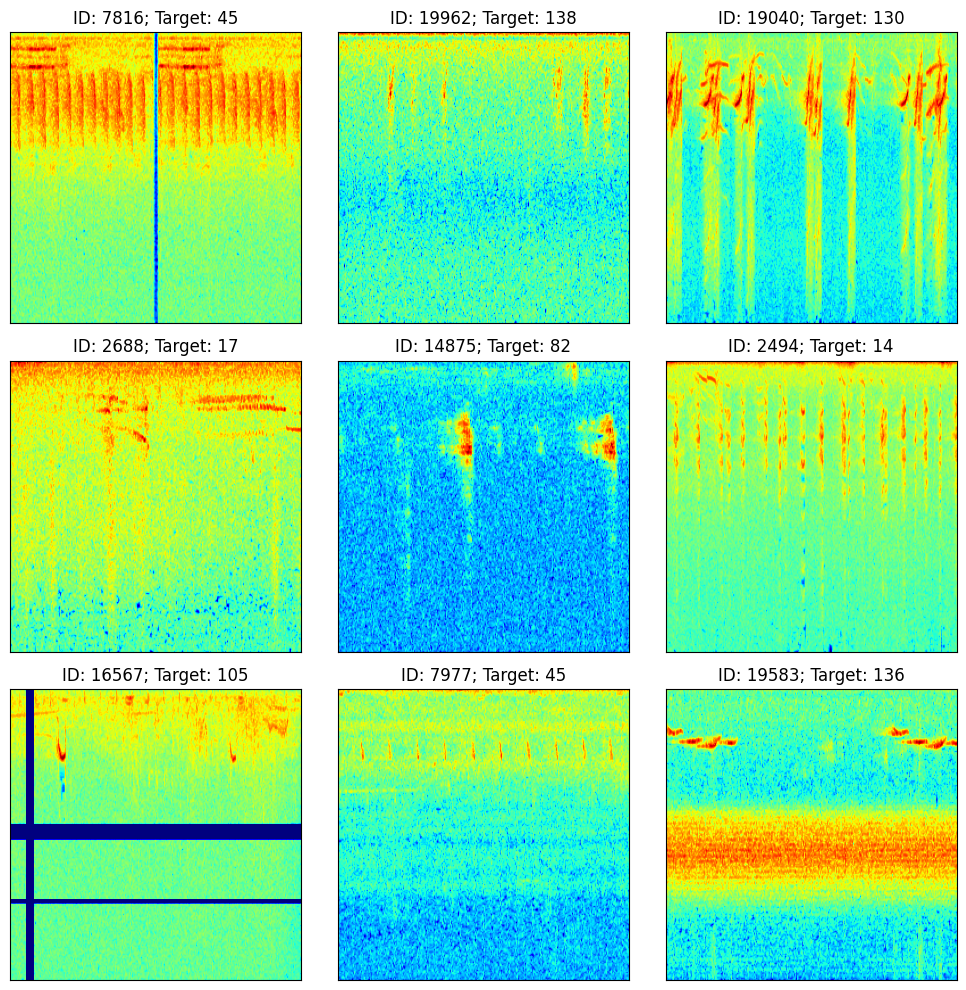

17848

In [13]:
dummy_dataset = BirdDataset(train_df, get_transforms('train'))

test_input, test_target = dummy_dataset[0]
print(test_input.detach().numpy().shape)

if config.VISUALIZE:
    show_batch(dummy_dataset)

del dummy_dataset
gc.collect()

# Model

## Network

In [14]:
class EffNet(nn.Module):

    def __init__(self, model_type, n_classes, pretrained=True):
        super().__init__()

        if model_type == 'efficientnet_b0':
            if pretrained: weights = efficientnet.EfficientNet_B0_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b0(weights=weights)
        elif model_type == 'efficientnet_b1':
            if pretrained: weights = efficientnet.EfficientNet_B1_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b1(weights=weights)
        elif model_type == 'efficientnet_b2':
            if pretrained: weights = efficientnet.EfficientNet_B2_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b2(weights=weights)
        elif model_type == 'efficientnet_b3':
            if pretrained: weights = efficientnet.EfficientNet_B3_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b3(weights=weights)
        else:
            raise ValueError('model type not supported')

        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, n_classes, dtype=torch.float32)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = torch.cat([x, x, x], dim=3).permute(0, 3, 1, 2)
        return self.base_model(x)

In [15]:
dummy_model = EffNet(config.MODEL_TYPE, n_classes=len(label_list))

dummy_input = torch.randn(2, 256, 256)
print(dummy_model(dummy_input).shape)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 109MB/s] 


torch.Size([2, 182])


## Model by PyTorch-Lightning

In [16]:
class BirdModel(pl.LightningModule):

    def __init__(self):
        super().__init__()

        # == backbone ==
        self.backbone = EffNet(config.MODEL_TYPE, n_classes=len(label_list))

        # == loss function ==
        self.loss_fn = nn.CrossEntropyLoss()

        # == record ==
        self.validation_step_outputs = []

    def forward(self, images):
        return self.backbone(images)

    def configure_optimizers(self):

        # == define optimizer ==
        model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=config.LR,
            weight_decay=config.WEIGHT_DECAY
        )

        # == define learning rate scheduler ==
        lr_scheduler = CosineAnnealingWarmRestarts(
            model_optimizer,
            T_0=config.EPOCHS,
            T_mult=1,
            eta_min=1e-6,
            last_epoch=-1
        )

        return {
            'optimizer': model_optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch',
                'monitor': 'val_loss',
                'frequency': 1
            }
        }

    def training_step(self, batch, batch_idx):

        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)

        # == pred ==
        y_pred = self(image)

        # == compute loss ==
        train_loss = self.loss_fn(y_pred, target)

        # == record ==
        self.log('train_loss', train_loss, True)

        return train_loss

    def validation_step(self, batch, batch_idx):

        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)

        # == pred ==
        with torch.no_grad():
            y_pred = self(image)

        self.validation_step_outputs.append({"logits": y_pred, "targets": target})

    def train_dataloader(self):
        return self._train_dataloader

    def validation_dataloader(self):
        return self._validation_dataloader

    def on_validation_epoch_end(self):

        # = merge batch data =
        outputs = self.validation_step_outputs

        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs], dim=0)).cpu().detach()
        target_val = torch.cat([x['targets'] for x in outputs], dim=0).cpu().detach()

        # = compute validation loss =
        val_loss = self.loss_fn(output_val, target_val)

        # target to one-hot
        target_val = torch.nn.functional.one_hot(target_val, len(label_list))

        # = val with ROC AUC =
        gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=label_list)
        pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=label_list)

        gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]

        val_score = score(gt_df, pred_df, row_id_column_name='id')

        self.log("val_score", val_score, True)

        # clear validation outputs
        self.validation_step_outputs = list()

        return {'val_loss': val_loss, 'val_score': val_score}

# Functions of Training Loop

In [17]:
def predict(data_loader, model):
    model.to(config.DEVICE)
    model.eval()
    predictions = []
    gts = []
    for batch in tqdm(data_loader):
        with torch.no_grad():
            x, y = batch
            x = x.cuda()
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        predictions.append(outputs.detach().cpu())
        gts.append(y.detach().cpu())

    predictions = torch.cat(predictions, dim=0).cpu().detach()
    gts = torch.cat(gts, dim=0).cpu().detach()
    gts = torch.nn.functional.one_hot(gts, len(label_list))

    return predictions.numpy().astype(np.float32), gts.numpy().astype(np.float32)

In [18]:
def run_training(fold_id, total_df):
    print('================================================================')
    print(f"==== Running training for fold {fold_id} ====")

    # == create dataset and dataloader ==
    train_df = total_df[total_df['fold'] != fold_id].copy()
    valid_df = total_df[total_df['fold'] == fold_id].copy()

    print(f'Train Samples: {len(train_df)}')
    print(f'Valid Samples: {len(valid_df)}')

    train_ds = BirdDataset(train_df, get_transforms('train'), 'train')
    val_ds = BirdDataset(valid_df, get_transforms('valid'), 'valid')

    train_dl = torch.utils.data.DataLoader(
        train_ds,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.N_WORKERS,
        pin_memory=True,
        persistent_workers=True
    )

    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=config.BATCH_SIZE * 2,
        shuffle=False,
        num_workers=config.N_WORKERS,
        pin_memory=True,
        persistent_workers=True
    )

    # == init model ==
    bird_model = BirdModel()

    # == init callback ==
    checkpoint_callback = ModelCheckpoint(monitor='val_score',
                                          dirpath=config.OUTPUT_DIR,
                                          save_top_k=1,
                                          save_last=False,
                                          save_weights_only=True,
                                          filename=f"fold_{fold_id}",
                                          mode='max')
    callbacks_to_use = [checkpoint_callback, TQDMProgressBar(refresh_rate=1)]

    # == init trainer ==
    trainer = pl.Trainer(
        max_epochs=config.EPOCHS,
        val_check_interval=0.5,
        callbacks=callbacks_to_use,
        enable_model_summary=False,
        accelerator="gpu",
        deterministic=True,
        precision='16-mixed' if config.MIXED_PRECISION else 32,
    )

    # == Training ==
    trainer.fit(bird_model, train_dataloaders=train_dl, val_dataloaders=val_dl)

    # == Prediction ==
    best_model_path = checkpoint_callback.best_model_path
    weights = torch.load(best_model_path)['state_dict']
    bird_model.load_state_dict(weights)

    preds, gts = predict(val_dl, bird_model)

    # = create dataframe =
    pred_df = pd.DataFrame(preds, columns=label_list)
    pred_df['id'] = np.arange(len(pred_df))
    gt_df = pd.DataFrame(gts, columns=label_list)
    gt_df['id'] = np.arange(len(gt_df))

    # = compute score =
    val_score = score(gt_df, pred_df, row_id_column_name='id')

    # == save to file ==
    pred_cols = [f'pred_{t}' for t in label_list]
    valid_df = pd.concat([valid_df.reset_index(), pd.DataFrame(np.zeros((len(valid_df), len(label_list)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
    valid_df[label_list] = gts
    valid_df[pred_cols] = preds
    valid_df.to_csv(f"{config.OUTPUT_DIR}/pred_df_f{fold_id}.csv", index=False)

    return preds, gts, val_score

# Training

## KFold

In [19]:
kf = KFold(n_splits=config.FOLDS, shuffle=True, random_state=config.SEED)
train_df['fold'] = 0
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    train_df.loc[val_idx, 'fold'] = fold

## Training Loop

In [20]:
# training
torch.set_float32_matmul_precision('high')

# record
fold_val_score_list = list()
oof_df = train_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
oof_df = pd.concat([oof_df, pd.DataFrame(np.zeros((len(oof_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)

for f in range(config.FOLDS):

    # get validation index
    val_idx = list(train_df[train_df['fold'] == f].index)

    # main loop of f-fold
    val_preds, val_gts, val_score = run_training(f, train_df)

    # record
    oof_df.loc[val_idx, label_list] = val_gts
    oof_df.loc[val_idx, pred_cols] = val_preds
    fold_val_score_list.append(val_score)

    # only training one fold
    break


for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f}')

# oof_gt_df = oof_df[['samplename'] + label_list].copy()
# oof_pred_df = oof_df[['samplename'] + pred_cols].copy()
# oof_pred_df.columns = ['samplename'] + label_list
# oof_score = score(oof_gt_df, oof_pred_df, 'samplename')
# print(f'OOF Score: {oof_score:.5f}')

oof_df.to_csv(f"{config.OUTPUT_DIR}/oof_pred.csv", index=False)

==== Running training for fold 0 ====
Train Samples: 22013
Valid Samples: 2446


2024-04-14 05:27:12.512556: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 05:27:12.512657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 05:27:12.653107: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /kaggle/working exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Fold 0 Val Score: 0.93847
